### Backprop

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [8]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [40]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item() # exactly equal then we are returning bool
  app = torch.allclose(dt, t.grad) # if it is approximately equal i.e slight floating point
  maxdiff = (dt - t.grad).abs().max().item() # largest diff
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [12]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [14]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [16]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3206, grad_fn=<NegBackward0>)

In [22]:
# WE need to get all the derivitives 
# 1.logprobs = probs.log()
# dlogprobs - stores the gradients

In [24]:
logprobs.shape

torch.Size([32, 27])

In [26]:
#dlogprobs will have the same size as logprobs

In [ ]:
# HOw does this logprobs effect loss:

In [28]:
Yb

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

In [30]:
logprobs[range(n), Yb]

tensor([-3.9481, -3.1019, -3.6463, -3.1768, -4.0415, -3.5625, -3.1120, -3.9818,
        -3.2309, -4.2221, -3.1284, -1.6282, -2.7474, -2.9955, -2.9120, -3.0980,
        -3.8373, -2.9730, -3.6488, -3.4030, -2.8623, -2.9612, -4.2750, -3.9932,
        -3.4201, -2.8390, -3.0218, -3.7930, -2.7993, -3.4700, -3.2597, -3.1708],
       grad_fn=<IndexBackward0>)

In [ ]:
#loss = -logprobs[range(n), Yb].mean()

In [32]:
#loss = -(a+b+c)/3  == mean

# dloss/da = 1/3  == d/dx(3x) = 3

#SO for all these logprobs[range(n), Yb] values the gradient = 1/n

# but in logprobs there are other values too their gradient will be 0 as they do not impact the loss

In [34]:
dlogprobs = torch.zeros_like(logprobs) # same shape as logprobs

In [36]:
n

32

In [38]:
dlogprobs [range(n), Yb] = -1.0/n # we set to -1/n

In [42]:
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


In [46]:
#dprobs
# d/dx(logx) = 1/x
# probs.log()

In [48]:
dprobs = (1.0/probs) * dlogprobs ## chain rule 

In [50]:
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


In [52]:
# if probs are correct then i.e if prob of correct is close to 1 then the change will be less if not
# it will boost its gradient

In [68]:
# counts * counts_sum_inv

In [60]:
# counts_sum_inv

In [62]:
counts_sum_inv .shape , counts.shape

(torch.Size([32, 1]), torch.Size([32, 27]))

In [64]:
# 1. it has to replicate the [32, 1] to all [32, 27]
# 2. multiply

In [66]:
# c = a*b
#db/dc = a

In [70]:
# dcounts_sum_inv = counts * dprobs  == this is for multiply

In [72]:
# a[3,3] * b[3,1] == a1*b1 a2*b1 a3*b1
# for replicating we sum to get the gradient and then we keep the dim to match  [32, 1] in its grad
#here b1 is just replicating with others in this case we just sum

In [74]:
dcounts_sum_inv = (counts * dprobs).sum(1 , keepdim = True)

In [76]:
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


In [78]:
#counts

In [82]:
#da/dc = b

In [84]:
dcounts = (counts_sum_inv * dprobs)

In [86]:
## we cannot do cmf - compare right now as counts is also changed later stages

In [88]:
#counts_sum**-1

In [94]:
#d/dx(x**-1) =  -1/x**2

In [96]:
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv

In [98]:
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


In [100]:
#counts_sum = counts.sum(1, keepdims=True)

In [102]:
counts.shape , counts_sum.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [106]:
# a11 a12 a13 = b1( a11 + a12 + a13)
# a21 a22 a23 = b1( a21 + a22 + a23)

In [110]:
# SUM derivitave just flows i.e here here 
#  (torch.ones_like(counts) * dcounts_sum) 
## remember we alredy has one dcounts so we do +=

In [112]:
dcounts += torch.ones_like(counts) * dcounts_sum

In [114]:
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


In [116]:
#counts = norm_logits.exp()

In [118]:
# d/dx(e^x) = e^x

In [120]:
# dnorm_logits = dnorm_logits ==counts

In [122]:
dnorm_logits = counts * dcounts

In [124]:
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


In [126]:
#norm_logits = logits - logit_maxes

In [128]:
logit_maxes.shape , logits.shape, norm_logits.shape

(torch.Size([32, 1]), torch.Size([32, 27]), torch.Size([32, 27]))

In [136]:
# C11 C12 C13 =  a11 a12 13  -  b1
#e.g c12 = a12 -b1
# just like above replication
#for a,b ...C just pass

In [134]:
dlogits =  dnorm_logits.clone() #just to save as we have logits in later stages

In [138]:
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True) # sum is for replication

In [140]:
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


In [142]:
#logit_maxes we are doing so exp doesnt overflow
#logit_maxes should not impact the probs and loss so it has to have less grad ~ 0

In [144]:
# may be in F.cross_entropy it might be 0 for logit_maxes

In [146]:
# logit_maxes = logits.max(1, keepdim=True).values

In [148]:
logits.max(1, keepdim=True)

torch.return_types.max(
values=tensor([[0.9586],
        [0.9069],
        [1.2378],
        [0.6116],
        [1.6625],
        [0.8982],
        [0.7917],
        [1.4901],
        [1.1190],
        [1.1087],
        [1.6831],
        [2.0754],
        [1.1236],
        [0.9850],
        [0.5694],
        [0.7755],
        [0.9710],
        [0.7376],
        [1.1236],
        [0.8626],
        [0.7840],
        [0.9868],
        [1.1236],
        [1.2908],
        [1.4747],
        [0.9420],
        [1.2897],
        [0.9223],
        [0.9950],
        [0.8541],
        [1.1674],
        [0.8996]], grad_fn=<MaxBackward0>),
indices=tensor([[ 1],
        [ 2],
        [19],
        [15],
        [15],
        [25],
        [16],
        [ 3],
        [19],
        [ 8],
        [15],
        [ 3],
        [22],
        [18],
        [ 7],
        [ 5],
        [ 2],
        [ 1],
        [22],
        [19],
        [15],
        [19],
        [22],
        [22],
        [23],
        [

In [150]:
# in forward pass we use only .values()

In [152]:
# we need to pass dlogit_maxes on max index 

In [154]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

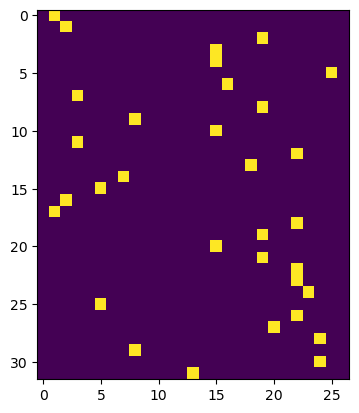

In [158]:
plt.show()

In [160]:
dlogit_maxes.shape

torch.Size([32, 1])

In [164]:
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])*dlogit_maxes

In [166]:
cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


In [168]:
# logits = h @ W2 + b2 # output layer

In [170]:
dlogits.shape , h.shape, W2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [174]:
# d = a@b+c

# d11 =  a11*b11 + a12*b12 + c1
# d12 =  a11*b21 + a12*b22 + c2

#dl/da11 = dL/dd11*b11 + dL/dd12*b12

#dl/da = [dL/a11 dL/a22] b^T


#dL/da = dL/dd @ b^T
#dL/db = a^T @ dL/dd
#dl/dc = dL/dd.sum()


#No need to remember these formulas but as u know h shoud have same shape as dh then u know there is 
#@ between logits and other var then by their shapes u can get an idea

In [176]:
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

In [178]:
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)

h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0


In [180]:
# h = torch.tanh(hpreact) # hidden layer

In [182]:
dhpreact = (1.0 - h**2) * dh # dh is chain rule and d/dx(tanh) = 1-x**2

In [184]:
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: True  | approximate: True  | maxdiff: 0.0


In [186]:
# hpreact = bngain * bnraw + bnbias

In [188]:
hpreact.shape, bngain.shape, bnraw.shape, bnbias.shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]))

In [202]:
#multiply rule of chain

In [204]:
dbngain = (bnraw*dhpreact).sum(0, keepdim=True) # sum is for replication of dim

In [206]:
dbnraw = bngain * dhpreact


In [208]:
#sum rule of chain

In [210]:
dbnbias =  dhpreact.sum(0, keepdim= True)# sum is for replication of dim

In [212]:
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)

bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0


In [214]:
# bnraw = bndiff * bnvar_inv 

In [216]:
bnraw.shape, bndiff.shape, bnvar_inv.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [268]:
dbndiff = bnvar_inv * dbnraw # multiply chain

In [220]:
dbnvar_inv = (bndiff * dbnraw).sum(0,keepdim =True)

In [226]:
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

bnvar_inv       | exact: True  | approximate: True  | maxdiff: 0.0


In [230]:
cmp('bndiff', dbndiff, bndiff) # we are not done with this

bndiff          | exact: False | approximate: False | maxdiff: 0.00104168348480016


In [232]:
#bnvar_inv = (bnvar + 1e-5)**-0.5

In [238]:
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv

In [240]:
cmp('bnvar', dbnvar, bnvar)

bnvar           | exact: True  | approximate: True  | maxdiff: 0.0


In [242]:
#bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)

In [244]:
#n-1 is like varience = /n-1 #unbiased
#population vs sample correction
#here we are dealing with mini batches as samples

In [246]:
bnvar.shape , bndiff2.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [248]:
# sum in forward pass - replication in  backward pass

In [252]:
## a11, a12

#b1 = 1/(n-1) * (a11+a21)
#b1 grads will have to flow through a

In [256]:
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar # replication will be done by broadcasting

In [258]:
cmp('bndiff2', dbndiff2, bndiff2)

bndiff2         | exact: True  | approximate: True  | maxdiff: 0.0


In [260]:
#bndiff2 = bndiff**2

In [ ]:
# d/dx x^2 = 2x 

In [270]:
dbndiff+= (2*bndiff) * dbndiff2

In [272]:
cmp('bndiff', dbndiff, bndiff)

bndiff          | exact: True  | approximate: True  | maxdiff: 0.0


In [274]:
# bndiff = hprebn - bnmeani

In [276]:
bndiff.shape, hprebn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [290]:
dhprebn = dbndiff.clone() # not done
# dbnmeani = (-torch.ones_like(dbndiff) * dbndiff).sum(0)
dbnmeani = (-dbndiff).sum(0)

In [284]:
cmp('bnmeani', dbnmeani, bnmeani)

bnmeani         | exact: True  | approximate: True  | maxdiff: 0.0


In [286]:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)

In [292]:
dhprebn+= 1.0/n * torch.ones_like(hprebn) *dbnmeani

In [294]:
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: True  | approximate: True  | maxdiff: 0.0


In [296]:
# hprebn = embcat @ W1 + b1 # hidden layer pre-activation

In [302]:
hprebn.shape, embcat.shape, W1.shape, b1.shape

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

In [304]:
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

In [306]:
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)

embcat          | exact: True  | approximate: True  | maxdiff: 0.0
W1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0


In [308]:
# embcat = emb.view(emb.shape[0], -1)

In [310]:
embcat.shape, emb.shape

(torch.Size([32, 30]), torch.Size([32, 3, 10]))

In [312]:
demb = dembcat.view(emb.shape)

In [314]:
cmp('emb', demb, emb)

emb             | exact: True  | approximate: True  | maxdiff: 0.0


In [316]:
# emb = C[Xb]

In [320]:
emb.shape, C.shape , Xb.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [322]:
print(Xb[:3])

tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9]])


In [324]:
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]

In [326]:
cmp('C', dC, C)

C               | exact: True  | approximate: True  | maxdiff: 0.0


In [328]:
# in the loss if u put together most them cancel out

In [330]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.320647716522217 diff: 0.0


In [332]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


In [335]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [337]:
F.softmax(logits, 1)[0]

tensor([0.0762, 0.0830, 0.0186, 0.0503, 0.0201, 0.0796, 0.0229, 0.0383, 0.0193,
        0.0310, 0.0329, 0.0376, 0.0380, 0.0296, 0.0350, 0.0140, 0.0101, 0.0202,
        0.0180, 0.0570, 0.0487, 0.0206, 0.0270, 0.0649, 0.0599, 0.0257, 0.0214],
       grad_fn=<SelectBackward0>)

In [339]:
# above are the probabilities

In [341]:
dlogits[0] * n

tensor([ 0.0762,  0.0830,  0.0186,  0.0503,  0.0201,  0.0796,  0.0229,  0.0383,
        -0.9807,  0.0310,  0.0329,  0.0376,  0.0380,  0.0296,  0.0350,  0.0140,
         0.0101,  0.0202,  0.0180,  0.0570,  0.0487,  0.0206,  0.0270,  0.0649,
         0.0599,  0.0257,  0.0214], grad_fn=<MulBackward0>)

In [345]:
# above are the grad(logits) , the -ve one is the correct answer and it is changing the direction

In [347]:
# if probs are exact correct 0 every where except 1 at correct index - then dlogits will be all 0's

In [349]:
# as the sum of whole row is 1 then increasing the correct prob will dec the wrong prob

In [357]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

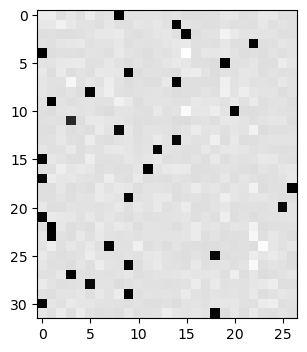

In [359]:
plt.show()